# Quickstart

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [3]:
import numpy as np
import pylab as plt
import swyft

from swyft.inference.marginalratioestimator import MarginalRatioEstimator
from swyft.networks.classifier import get_marginal_classifier

## Setup the forward model

In [4]:
device = 'cuda' if swyft.utils.is_cuda_available() else "cpu"
n_training_samples = 10_000
n_parameters = 2
marginal_indices_1d, marginal_indices_2d = swyft.utils.get_corner_marginal_indices(n_parameters)
observation_key = "x"

/home/ben/sci/swyft/env/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630839582/work/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
def model(v, sigma = 0.2):
    x = v + np.random.randn(n_parameters) * sigma
    return {observation_key: x}

v_o = np.zeros(n_parameters)
observation_o = model(v_o, sigma = 0.)

n_observation_features = observation_o[observation_key].shape[0]
observation_shapes = {key: value.shape for key, value in observation_o.items()}

In [6]:
simulator = swyft.Simulator(
    model, 
    n_parameters, 
    sim_shapes=observation_shapes
)

## Setup the prior and storage

In [7]:
store = swyft.Store.memory_store(simulator)

Creating new store.


In [8]:
low = -1 * np.ones(n_parameters)
high = 1 * np.ones(n_parameters)
prior = swyft.get_uniform_prior(low, high)
store.add(n_training_samples, prior)
store.simulate()

Store: Adding 9844 new samples to simulator store.


In [9]:
dataset = swyft.Dataset(n_training_samples, prior, store)

## Train a 1d marginal estimator

In [10]:
network_1d = get_marginal_classifier(
    observation_key=observation_key,
    marginal_indices=marginal_indices_1d,
    observation_shapes=observation_shapes,
    n_parameters=n_parameters,
    hidden_features=32,
    num_blocks=2,
)

mre_1d = MarginalRatioEstimator(
    marginal_indices=marginal_indices_1d,
    network=network_1d,
    device=device,
)

In [11]:
mre_1d.train(dataset)

training: lr=5e-06, epoch=25, validation loss=1.7272

## Create a simple violin plot to view the 1d marginals

In [12]:
n_rejection_samples = 5_000

posterior_1d = swyft.MarginalPosterior(mre_1d, prior)
samples_1d = posterior_1d.sample(n_rejection_samples, observation_o)

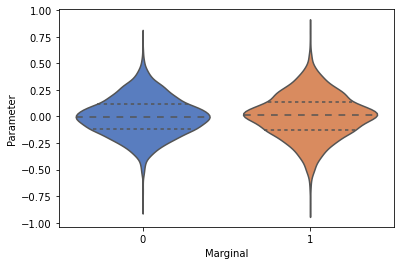

In [13]:
_ = swyft.violin(samples_1d)

## Train a 2d marginal estimator

In [14]:
network_2d = get_marginal_classifier(
    observation_key=observation_key,
    marginal_indices=marginal_indices_2d,
    observation_shapes=observation_shapes,
    n_parameters=n_parameters,
    hidden_features=32,
    num_blocks=2,
)

mre_2d = MarginalRatioEstimator(
    marginal_indices=marginal_indices_2d,
    network=network_2d,
    device=device,
)

In [15]:
mre_2d.train(dataset)

training: lr=5e-05, epoch=25, validation loss=0.50517

## Combine the two to create a corner plot

In [16]:
n_weighted_samples = 10_000

posterior_1d = swyft.MarginalPosterior(mre_1d, prior)
weighted_samples_1d = posterior_1d.weighted_sample(n_weighted_samples, observation_o)

posterior_2d = swyft.MarginalPosterior(mre_2d, prior)
weighted_samples_2d = posterior_2d.weighted_sample(n_weighted_samples, observation_o)

1it [00:04,  4.21s/it]


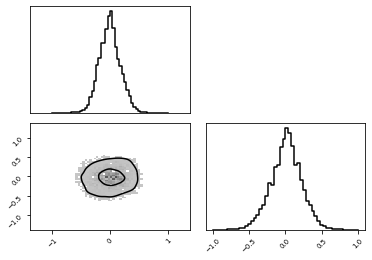

In [17]:
_, _ = swyft.plot.corner(
    weighted_samples_1d.get_df_dict(), 
    weighted_samples_2d.get_df_dict(),
    kde=True
)

## Test the expected coverage probability

In [18]:
n_observations = 200
n_posterior_samples = 5_000

empirical_mass_1d, _ = posterior_1d.empirical_mass(n_observations, n_posterior_samples, dataset)
empirical_mass_2d, _ = posterior_2d.empirical_mass(n_observations, n_posterior_samples, dataset)

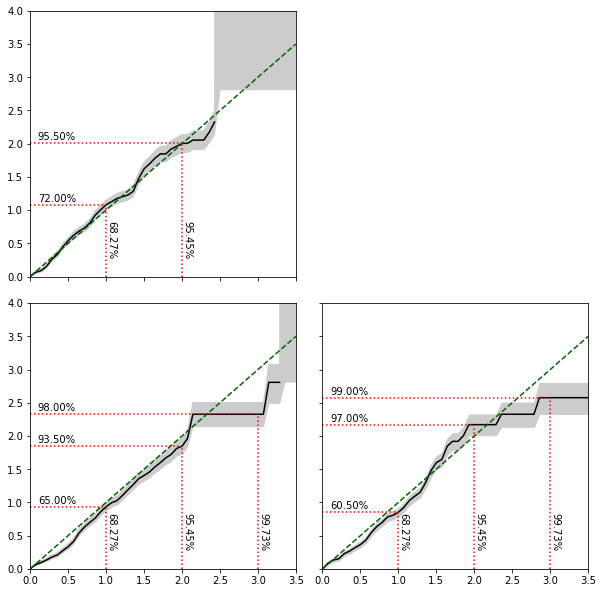

In [19]:
_, _ = swyft.empirical_z_score_corner(empirical_mass_1d, empirical_mass_2d, figsize=(10,10))